# Make a minimalist movie showing tip trajectories
Tim Tyree<br>
11.16.2020

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import skimage as sk
from skimage import measure, filters

from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

# #load the libraries
from lib import *
# from lib.measure._find_tips_pbc_cy import lookup_segments
# from lib.measure._find_tips_kernel import *
# from lib.measure._find_tips_kernel_cy import find_intersections
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


# for one ic, compute two frames at 25ms apart (real time)


In [2]:
#TODO(later): plot these tips with their u's and v's
# Display the image and plot all pbc contours found properly!
def save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
    save = True, inch = 6, **kwargs):
    ''''''
    fig, ax = plt.subplots(figsize=(inch,inch))

    #appears to work     contours1 = find_contours(img,    level = 0.5)
    contours1 = find_contours(img,    level = V_threshold)
    contours2 = find_contours(dimgdt, level = 0.0)

    # ax.imshow(img, cmap=plt.cm.gray)
    ax.imshow(dimgdt, cmap=plt.cm.gray)
    # ax.imshow(dimgdt*img, cmap=plt.cm.gray)


    plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=6, linestyle='-', alpha=0.5, color='blue')
    plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=6, linestyle='--', alpha=0.5, color='orange')

    #plot spiral tips. color inner spiral tip by slow variable
    ax.scatter(x=x_values, y=y_values, s=270, c=1+0.*c_values, marker='*', zorder=3, alpha=1., vmin=0,vmax=1)
    ax.scatter(x=x_values, y=y_values, s=45, c=c_values, marker='*', zorder=3, alpha=1., vmin=0,vmax=1, cmap='Blues')
    # ax.scatter(x=x_values, y=y_values, s=270, c='yellow', marker='*', zorder=3, alpha=1.)
    # ax.scatter(x=x_values, y=y_values, s=45, c='blue', marker='*', zorder=3, alpha=1.)

    ax.text(.0,.95,f"t = {t*10**3:.2} s",
            horizontalalignment='left',color='white',fontsize=16,
            transform=ax.transAxes)
    ax.text(.0,.9,f"Num. of Tips  = {n_tips}",
            horizontalalignment='left',color='white',fontsize=16,
            transform=ax.transAxes)
    ax.text(.5,.01,f"Area = {25}cm^2, V. Threshold = {V_threshold}",
            horizontalalignment='center',color='white',fontsize=16,
            transform=ax.transAxes)

    # ax.set_title(f"Area ={25}cm^2, V. Threshold ={V_threshold}, Num. Tips ={n_tips}", color='blue', loc='left',pad=0)
    ax.axis([0,200,0,200])
#     ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])

    if not save:
        plt.show()
    else:
        os.chdir(save_folder)
        save_fn = f"img{frameno:07d}.png"
        frameno += 1
#         plt.tight_layout()
        plt.savefig(save_fn,dpi=720/inch, bbox_inches='tight',pad_inches=0);
        plt.close();
        #     print(f'figure saved in {save_fn}.')
        #     plt.savefig('example_parameterless_tip_detection_t_600.png')
    return frameno

In [4]:
#import a texture
# ## practical test case for fast tip detection kernel
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
# txt = load_buffer(file)
# t   = 0. #ms

# #load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
txt  = load_buffer(file)
t   = 500 #ms

# #load a mesh from Luo-Rudy that is near termination
# txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_900.0.npz'
# t=900.
# txt=load_buffer(txt_fn)
# inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)



# #define tip detection routine parameters
# V_threshold = 0.4
# decimals=10
# theta_threshold = 0.
# level1 = V_threshold
# level2 = 0.0
# h    = 0.025 #ms

#define tip detection routine parameters
V_threshold = -40
decimals=10
theta_threshold = 0.
level1 = V_threshold
level2 = 0.0
h    = 0.001 #ms


zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

t_list = []
n_list = []   
dict_lst = []


In [ ]:
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.001,Cm=1.0)

In [5]:
# tmax = 25#30000#6000#3025.600-2*h# 886.6-h#6000#600#510#600#505.225# #ms
num_steps = 1#int(np.around((tmax-t)/h))
tmax = h*num_steps+t
print(tmax)
step_count = 0
while t<tmax:
    #TODO: insert functionality for saving every n frames

#     #measure system with cython
#     #compute as discrete flow map dtxt_dt
#     dtxt_dt = zero_txt.copy()
#     get_time_step(txt, dtxt_dt)

#     #compute the images to find isosurfaces of
#     img    = txt[...,0]
#     dimgdt = dtxt_dt[...,0]

    # find_intersections
    retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
    lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
    x_values = np.array(lst_values_x)
    y_values = np.array(lst_values_y)
    # EP states given by bilinear interpolation with periodic boundary conditions
    v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
    dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)

    n_tips = x_values.size
    dict_out = {
        't': float(t),
        'n': int(n_tips),
        'x': tuple(lst_values_x),
        'y': tuple(lst_values_y),
        'theta': tuple(lst_values_theta),
        'grad_ux': tuple(lst_values_grad_ux),
        'grad_uy': tuple(lst_values_grad_uy),
        'grad_vx': tuple(lst_values_grad_vx),
        'grad_vy': tuple(lst_values_grad_vy),
        'v':v_lst,
        'f':f_lst,
        's':s_lst,
        'dvdt':dvdt_lst,
        'dfdt':dfdt_lst,
        'dsdt':dsdt_lst,
    }
    dict_lst.append(dict_out)
    
    #record data for current time
    t_list.append(t)
    n_list.append(n_tips)

    #forward Euler integration in time
    txt += h*dtxt_dt
    t   += h
    step_count += 1
    
    #progress bar that updates after each measurement
    printProgressBar(step_count, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
beep(1)
print(f"\nthe current tip number is {n_tips}.")

900.001


NameError: name 'get_time_step' is not defined

In [9]:
# plt.imshow(dimgdt,cmap='gray')
min_time_between_samples = 1 #milliseconds
frameno = 1
save_every_n_frames = int(min_time_between_samples/h)

#create a save_folder if it doesn't already exist
os.chdir(nb_dir)
base_folder = os.path.join(nb_dir,f'Figures/mov/ic_{"test"}_V_{V_threshold}')
save_folder_name = f'frame_every_{min_time_between_samples}_ms'
save_folder = os.path.join(base_folder,save_folder_name)

if not os.path.exists(base_folder):
    os.mkdir(base_folder)
    print(f"created save folder at {base_folder}")
os.chdir(base_folder)
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    print(f"created save folder at {save_folder}")
os.chdir(save_folder)

created save folder at /Users/timothytyree/Documents/GitHub/care/notebooks/Figures/mov/ic_test_V_0.4/frame_every_1_ms


In [10]:
#save the state of the system
c_values = np.array(dfdt_lst)
# c_values = np.array(s_lst)
frameno = save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
    save = True, inch = 6)

In [11]:
tmax = 300000#30000#6000#3025.600-2*h# 886.6-h#6000#600#510#600#505.225# #ms
num_steps = int(np.around((tmax-t)/h))
tmax = h*num_steps+t
# print(tmax)
step_count = 0
while (t<tmax) & (n_tips > 0):
    if step_count%save_every_n_frames != 0:
        #forward Euler integration in time
        time_step(txt, h, zero_txt)
    else:
        #measure system with cython
        #compute as discrete flow map dtxt_dt
        dtxt_dt = zero_txt.copy()
        get_time_step(txt, dtxt_dt)

        #compute the images to find isosurfaces of
        img    = txt[...,0]
        dimgdt = dtxt_dt[...,0]

        # find_intersections
        retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
        lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
        x_values = np.array(lst_values_x)
        y_values = np.array(lst_values_y)
        # EP states given by bilinear interpolation with periodic boundary conditions
        v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
        dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)



        n_tips = x_values.size
        dict_out = {
            't': float(t),
            'n': int(n_tips),
            'x': tuple(lst_values_x),
            'y': tuple(lst_values_y),
            'theta': tuple(lst_values_theta),
            'grad_ux': tuple(lst_values_grad_ux),
            'grad_uy': tuple(lst_values_grad_uy),
            'grad_vx': tuple(lst_values_grad_vx),
            'grad_vy': tuple(lst_values_grad_vy),
            'v':v_lst,
            'f':f_lst,
            's':s_lst,
            'dvdt':dvdt_lst,
            'dfdt':dfdt_lst,
            'dsdt':dsdt_lst,
        }
        dict_lst.append(dict_out)

        #record data for current time
        t_list.append(t)
        n_list.append(n_tips)

        #save the state of the system as a png
        c_values = np.array(dfdt_lst)#s_lst)
        frameno = save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
                                   save = True, inch = 6)
        #progress bar that updates after each measurement
        printProgressBar(step_count, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)

        #forward Euler integration in time
        txt += h*dtxt_dt
    t   += h
    step_count += 1
    
beep(3)
print(f"\nthe current tip number is {n_tips}.")

Progress: |█-------------------------------------------------| 3.0% Complete
the current tip number is 0.


In [ ]:
#TODO: make a *.mov of ^this
#TODO(later): compute the trajectories of spiral tips.
#TODO(later): color tips by their particle number.
#TODO(later): make a *.mov of ^this
#TODO(later): does ^this look reasonable

In [1]:
# save_plot_as_png(img, dimgdt, x_values, y_values, c_values, n_tips, V_threshold, t, save_folder, frameno, 
#                                    save = True, inch = 6)

In [22]:
#TODO: time step forward 25ms
#TODO: print dV/dt to file

contour_lst = split_contour_into_contiguous(contours1[0])
ct = contour_lst[0]
print(len(contour_lst))

9


In [23]:
min_num_vertices = 3
pop_until_long_enough(lst_lst=contour_lst,min_length=min_num_vertices)
print(len(contour_lst))

8


# TODO: color solid blue contour by local contour curvature

- TODO: integrate some integral measure of string curvature between the "high"-halves of the contour2 family of $dV/dt=0$. __I observe that tips move in the direction their nonlocal string dictates.

In [6]:
#TODO: download an audio track to put into the background of the movie before the prepending intro.MTS
# !youtube-dl https://youtu.be/O2KUTa6P6lM -pxl_fmt 720hd -o tmp.mka
# !youtube-dl https://www.youtube.com/watch?v=O2KUTa6P6lM&ab_channel=ThePochaccos

# TODO: do ^this at a high resolution near a termination event from the LR model

In [2]:
#not used in save_figure_as_png
def get_time_step(frameno,t,t_unit_string="s"):
    return f"frame={frameno}"
#     return f"t = {t*10**3:.2} "+t_unit_string

def get_message(ntips):
    return f"Num. of Tips  = {ntips}"

#TODO(later): plot these tips with their u's and v's
# Display the image and plot all pbc contours found properly!
def save_figure_as_png(fig,ax,save_folder,save_fn,time_step,inch = 6, **kwargs):
    '''
    Example Usage:
    
    '''
    ax.text(.0,.95,time_step,
            horizontalalignment='left',color='white',fontsize=16,
            transform=ax.transAxes)
    ax.text(.0,.9,message,
            horizontalalignment='left',color='white',fontsize=16,
            transform=ax.transAxes)
#     ax.text(.5,.01,f"Area = {25}cm^2, V. Threshold = {V_threshold}",
#             horizontalalignment='center',color='white',fontsize=16,
#             transform=ax.transAxes)
    os.chdir(save_folder)
    save_fn = f"img{frameno:07d}.png"
    frameno += 1
#         plt.tight_layout()
    fig.savefig(save_fn,dpi=720/inch, bbox_inches='tight',pad_inches=0);
    plt.close();
    return os.path.abspath(save_fn)

# def plot_system(img,dimgdt,V_threshold=-40):
# #     #visually verify system
# #     img=inVc[...,0]
# #     dimgdt=dVcdt[...,0]
#     # compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
#     # dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
#     #     print(f"{ntips} tips are present at time t={int(t_prev)}.")
#     fig = ShowDomain(img,dimgdt,x_values,y_values,0.*x_values,V_threshold,t,inch=6,fontsize=16,vmin_img=-85.,vmax_img=35.,
#                      area=25,frameno=1,save_fn=None,save_folder=None,save=False,annotating=False,axis=[0,txt.shape[0],0,txt.shape[1]])
#     ax_list = fig.axes
#     return fig

In [3]:
0.4*(35+85)-85

-37.0

In [4]:
def save_system_as_png(img,dimgdt,x_values,y_values,c_values,V_threshold,
            frameno,
            save_folder,
            save_fn):
    #visually verify system
    # compute_all_spiral_tips= get_compute_all_spiral_tips(mode='simp',width=width,height=height)
    # dict_out=compute_all_spiral_tips(t,img,dimgdt,level1=V_threshold,level2=0.)#,width=width,height=height)
    # print(f"{ntips} tips are present at time t={int(t_prev)}.")
    fig = ShowDomain(img,dimgdt,x_values,y_values,c_values,V_threshold,t,inch=6,
                     fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                     frameno=frameno,
                     save_fn=save_fn,
                     save_folder=save_folder,
                     save=True,
                     annotating=True,
                     axis=[0,img.shape[0],0,img.shape[1]])
    return save_fn

In [10]:
# ic_fn=search_for_file()
txt_fn=f"{nb_dir}/Data/initial-conditions-suite-3-LR/ic-out/ic008.33.npz"
txt=load_buffer(ic_fn)
t=0

# #load a mesh from Luo-Rudy that is near termination
# txt_fn=f'{nb_dir}/Data/test_data/ic008.33_t_750.0.npz'
# t=750.

save_folder=f'{nb_dir}/Figures/mov'
ds=5.
frameno=1
txt=load_buffer(txt_fn)
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
width,height=txt.shape[:2]
V_threshold=-50;dt=0.01


In [11]:
comp_dict_topo_full_color=get_comp_dict_topo_full_color(width=width,height=height,level1=V_threshold,level2=V_threshold)
# get_one_step at this dt
__, arr39, one_step = get_one_step_explicit_synchronous_splitting(
    nb_dir,dt=dt,width=width,height=height,ds=ds,diffCoef=0.0005,Cm=1.0)
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
DT=2.
nsteps_per_DT=int(DT/dt)

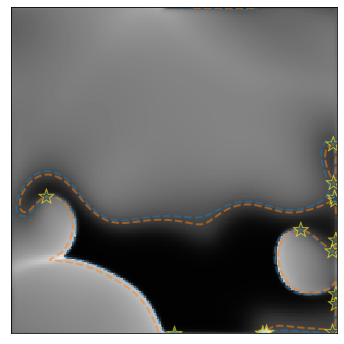

(14, 200, 0.01)

In [8]:
#comp img_prev example
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
img_prev=inVc[...,0].copy()
for n in range(nsteps_per_DT):
    one_step(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt)
    t+=dt
txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()
img=inVc[...,0];#dimgdt=dVcdt[...,0]
#compute tips
# dict_topo=comp_dict_topo_simple(img,dimgdt,t)
# dict_topo=comp_dict_topo_full_color(img,dimgdt,t,txt)
dict_topo=comp_dict_topo_full_color(img,img_prev,t,txt)
ntips=len(dict_topo['x'])
#init for tip recording
pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
t_prev=t;txt_prev=txt.copy()
# #zoom system
# txt,pdict=zoom_system(txt,pdict)
# txt,pdict=zoom_system(txt,pdict)
# dt=dt/10
# width,height=txt.shape[:2]
# comp_dict_topo_simple=get_comp_dict_topo_simple(width=width,height=height,level1=V_threshold,level2=0)
x_values,y_values,pid_values=pdict.get_current_locations()
inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# # #compute tips
# # inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
# # img=inVc[...,0];dimgdt=dVcdt[...,0]
# # # dict_topo=comp_dict_topo_simple(img,dimgdt,t)
# # dict_topo=comp_dict_topo_full_color(img,dimgdt,t,txt)

# # ntips=len(dict_topo['x'])
# # init for tip recording
# width,height=img.shape[:2]
# pdict=ParticlePBCDict(dict_tips=dict_topo, width=width, height=width)#, **kwargs)
# # t_prev=t;txt_prev=txt.copy();
# x_values,y_values,pid_values=pdict.get_current_locations()
c_values=pid_values/3
ShowDomain(img,img_prev,x_values,y_values,c_values,V_threshold,t,inch=6,
                     fontsize=16,vmin_img=-85.,vmax_img=35.,area=25,
                     frameno=frameno,
                     save_fn=None,
                     save_folder=None,
                     save=False,
                     annotating=False,
                     axis=[0,img.shape[0],0,img.shape[1]])


# ntips=x_values.shape[0]
ntips,width,dt

In [12]:
if not os.path.exists(save_folder):
    os.mkdir(save_folder)

In [13]:
save_every_n_frames=20

# while there are tips,
img_item_lst=[]
# while t<940:
while ntips>0:
    txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()

    #compute tips
#     inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    img=inVc[...,0].copy()#;dimgdt=dVcdt[...,0]
    img_item_lst.append((t,img))
    
    #recall img_prev, which is voltage at a time DT earlier
    t_a,img_prev=img_item_lst[0]
    DT_img_item_lst=t-t_a
    if DT_img_item_lst>=DT:
        img_item_lst.pop(0)

        #     dict_topo=comp_dict_topo_simple(img,dimgdt,t)
        dict_topo=comp_dict_topo_full_color(img,img_prev,t,txt)
        ntips=len(dict_topo['x'])
        pdict.merge(dict_topo)
        t_prev=t;txt_prev=txt.copy();
        x_values,y_values,pid_values=pdict.get_current_locations()
        c_values=pid_values/3
        frameno+=1
        #     ntips=x_values.shape[0]
        #     print(f"number of tips: {ntips}... t={t:.6f}\r")
    
        #     save png
        save_system_as_png(img,img_prev,x_values,y_values,c_values,V_threshold,
                frameno,
                save_folder=save_folder,
                save_fn=None)
        print(f"ntips={ntips}, time={t:.2f} ms.", end='\r')

    for j in range(save_every_n_frames):
        #     integrate forward by one_step
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
        
beep(5)

0

In [14]:
#TODO(later): zoom into system recursively

In [40]:
save_every_n_frames=10

# while there are tips,
# while ntips>0:
img_item_lst=[]
while t<940:
    txt=stack_txt(inVc,outVc,inmhjdfx,outmhjdfx,dVcdt).copy()

    #compute tips
#     inVc,outVc,inmhjdfx,outmhjdfx,dVcdt=unstack_txt(txt)
    img=inVc[...,0];dimgdt=dVcdt[...,0]
#     dict_topo=comp_dict_topo_simple(img,dimgdt,t)
    dict_topo=comp_dict_topo_full_color(img,dimgdt,t,txt)
    ntips=len(dict_topo['x'])
    pdict.merge(dict_topo)
    t_prev=t;txt_prev=txt.copy();
    x_values,y_values,pid_values=pdict.get_current_locations()
    c_values=pid_values/5
    frameno+=1
#     ntips=x_values.shape[0]
#     print(f"number of tips: {ntips}... t={t:.6f}\r")
    
    #     save png
    save_system_as_png(img,dimgdt,x_values,y_values,c_values,V_threshold,
            frameno,
            save_folder=save_folder,
            save_fn=None)

    for j in range(save_every_n_frames):
        #     integrate forward by one_step
        one_step(inVc, outVc, inmhjdfx, outmhjdfx, dVcdt)
        t+=dt
        
beep(5)

0

# analyze pdict

In [18]:
pl=pdict.get_alive_particles()
pl

[3, 39]

In [30]:
# plot sigma_max of the lesser_arclen versus time for all particles, centering about their last recorded time
fontsize=18
saving=True
savefig_folder=f"{nb_dir}/Figures"
savefig_fn=f"arclen-versus-ttdeath.png"
figsize=(6,5)
fig,ax=plt.subplots(figsize=figsize)

pid_lst=list(pdict.keys())
pid_lst=pdict.get_alive_particles()

# pid_lst=pdict.get_alive_particles()
for pid in pid_lst[:1]:
    #extract values
    sigma_max_values=np.array(pdict[pid]['greater_arclen'])
    sigma_max_values_other=np.array(pdict[pid]['lesser_arclen'])
    t_values=np.array(pdict[pid]['t'])
    t_until_death_values=t_values[-1]-t_values
    x_values=t_until_death_values
    y_values=sigma_max_values*5/img.shape[0]
    y_values_other=sigma_max_values_other*5/img.shape[0]
    
    #plot values
    ax.scatter(x_values,y_values,alpha=0.2)
    ax.scatter(x_values,y_values_other,alpha=0.2)
#format
ax.set_xlim([8e-3,2e1])
ax.set_ylim([1e-2,10])
ax.set_xlabel('time until death (ms)', fontsize=fontsize)
ax.set_ylabel('arclength of\nactivation front (cm)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_xscale('log')
ax.set_yscale('log')
if not saving: 
    plt.show() 
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
    print(f"saved figure in \n\t{savefig_fn}")
    plt.close()

saved figure in 
	arclen-versus-ttdeath.png


In [53]:
len(dict_topo['x'])

12